# Customer Churn Prediction P2

This is a new notebook to work with previous files from the notebook "model1_p1.ipynb". I will continue dividing the data between train & test.

## Train/Test split

Starting by loading the dataset and splitting it into X and y (Features and target).

In [1]:
import pandas as pd    
import numpy as np          
import pickle
from datetime import datetime      
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Defining global variables that will be used to save the state.
df, X, y = None, None, None 
X_train, X_test, y_train, y_test, X_train_balanced, y_train_balanced = None, None, None, None, None, None 
scaler, encoding_info, feature_importance = None, None, None
models = {}
results = {}



In [3]:
def load_data(csv_file, objects=None):
    """Load the preprocessed dataset and its objects."""
    
    global df, X, y, scaler, encoding_info, feature_importance
    
    try:
        # Loading dataset as dataframe.
        df = pd.read_csv(csv_file)
        print(f'Dataset loaded successfully!')
        print(f'\nRows: {df.shape[0]}')
        print(f'\nColumns: {df.shape[1]}')
        
        # Loading objects.
        if objects:
            with open(objects, 'rb') as f:
                objects = pickle.load(f)
                scaler = objects.get('scaler')
                encoding_info = objects.get('encoding_ïnfo')
                feature_importance = objects.get('feature_importance')
            print(f'Objects loaded from: {objects}')
        
        # Splitting in X and y.
        if 'Churn' in df.columns:
            X = df.drop(columns=['Churn'], axis=1)
            y = df['Churn']
            print(f'Features (X): {X.shape[0]}')
            print(f'Target (y): {y.shape}')
        else:
            print(f'Churn column not found.')
        
    except Exception as e:
        print(f'Encountered error while loading data: {str(e)}')
    

In [4]:
file = '../src/telco_churn_processed.csv'
model_objects = '../src/telco_churn_processed_objects.pkl'

load_data(file, model_objects)

Dataset loaded successfully!

Rows: 7021

Columns: 31
Objects loaded from: {'scaler': StandardScaler(), 'encoding_info': {'MultipleLines': {'type': 'onehot', 'columns': ['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes']}, 'InternetService': {'type': 'onehot', 'columns': ['InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No']}, 'OnlineSecurity': {'type': 'onehot', 'columns': ['OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes']}, 'OnlineBackup': {'type': 'onehot', 'columns': ['OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes']}, 'DeviceProtection': {'type': 'onehot', 'columns': ['DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes']}, 'TechSupport': {'type': 'onehot', 'columns': ['TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes']}, 'StreamingTV': {'type': 'onehot', 'columns': ['StreamingTV_No', 'StreamingTV_No internet service', 'Streaming

Next split will be between train data and test data.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def train_test_split_data(test_size=0.2, random_state=42, stratify=True):
    """Splits the dataset into train and test."""
    global X_train, X_test, y_train, y_test
    
    
    try:
        # Check for features and targets.
        if X is None or y is None:
            print(f'Load the data first!')
            return False 

        # Setting up stratify.
        stratify_param = y if stratify else None
         
        # Train/test split.
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=stratify_param)
        
        print(f'TRAIN/TEST SPLIT COMPLETED!')
        print(f'-'*50)
        print(f'Training set: {X_train.shape}')
        print(f'Test set: {X_test.shape}')
 
    except Exception as e:
        print(f'Encountered error in train/test split: {str(e)}')
        return False 

In [7]:
train_test_split_data()

TRAIN/TEST SPLIT COMPLETED!
--------------------------------------------------
Training set: (5616, 30)
Test set: (1405, 30)


After the second split, we have to handle the class imbalance that we found out on the EDA process. There are plenty of techniques to balance a dataset. 

We could choose between oversampling techinques (SMOTE, ADASYIN, RandomOverSampler), undersampling techniques (RamdomUnderSampler, TomekLinks) or combined over/undersampling techniques (SMOTETomek, SMOTEENN).

In [8]:
from collections import Counter 
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

In [10]:
def balance_tech(tech='smote', sampling_strategy='auto', random_state=42):
    """Applies balance techniques to the dataset."""
    global X_train_balanced, y_train_balanced
    
    # First check.
    if X_train is None or y_train is None:
        print(f'Do the train/test split first!')
        return False
    
    print(f'Applying balancing technique: {tech}')
    print(f'-'*50)
    
    # Original distribution.
    origin_dist = Counter(y_train)
    print(f'Original distribution: {dict(origin_dist)}')
    
    
    try:
        # Selecting technique.
        if tech == 'smote':
            sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        elif tech == 'adasyn':
            sampler = ADASYN(sampling_strategy=sampling_strategy, random_state=random_state)
        elif tech == 'random_over':
            sampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
        elif tech == 'random_under':
            sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
        elif tech == 'tomek':
            sampler = TomekLinks()
        elif tech == 'smote_tomek':
            sampler = SMOTETomek(sampling_strategy=sampling_strategy, random_state=random_state)
        elif tech == 'smote_enn':
            sampler = SMOTEENN(sampling_strategy=sampling_strategy, random_state=random_state)
        else:
            print(f'Techinque {tech} not recognised.')
            return False 
        
        # Applying balance.
        X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        # Distribution after balance.
        new_dist = Counter(y_train_balanced)
        print(f'Balanced distribution: {dict(new_dist)}')
        
        # Showing changes.
        print(f'\n CHANGES APPLIED:')
        print(f'-'*50)
        print(f'Original size: {len(y_train)} samples')
        print(f'Balance size: {len(y_train_balanced)} samples')
        print(f'Change: {len(y_train_balanced) - len(y_train):+d} samples.')
        
        for class_val in [0,1]:
            original_count = origin_dist[class_val]
            new_count = new_dist[class_val]
            change = new_count - original_count
            print(f'Class {class_val}: {original_count} -> {new_count} ({change:+d})')
        
        # New ratio.
        new_ratio = new_dist[0] / new_dist[1]
        print(f'New ratio: {new_ratio:.2f}:1')
        print(f'Dataset balanced succesfully with {tech}!')
        return True  
    
    except Exception as e:
        print(f'Encountered error while applying balanced technique: {str(e)}')
        return False 
        

In [11]:
balance_tech()

Applying balancing technique: smote
--------------------------------------------------
Original distribution: {1: 1485, 0: 4131}
Balanced distribution: {1: 4131, 0: 4131}

 CHANGES APPLIED:
--------------------------------------------------
Original size: 5616 samples
Balance size: 8262 samples
Change: +2646 samples.
Class 0: 4131 -> 4131 (+0)
Class 1: 1485 -> 4131 (+2646)
New ratio: 1.00:1
Dataset balanced succesfully with smote!


True

In this case i used SMOTE, but we could choose whatever technique we prefer.

## Model Developing

Next step will be to configure the models to be trained and make predictions.

Previous to the training, i'm going to initialize the models.

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb


In [13]:
def initialize_models():
    """Initialize the models to train."""
    global models
    
    # Configurating models.
    models = {
        'logistic_regression' : LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'random_forest' : RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=1),
        'gradient_boosting' : GradientBoostingClassifier(random_state=42, n_estimators=100),
        'xgboost' : xgb.XGBClassifier(random_state=42, eval_metric='logloss',n_estimators=100),
        'lightgbm': lgb.LGBMClassifier(random_state=42, n_estimators=100, verbose=-1)       
    }
    # Showing models.
    print(f'Initialized models: {len(models)}')
    print(f'-'*40)
    for name in models.keys():
        print(f'    * {name}')

In [14]:
initialize_models()

Initialized models: 5
----------------------------------------
    * logistic_regression
    * random_forest
    * gradient_boosting
    * xgboost
    * lightgbm


Following this step, the training will start and display its metrics.

In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score 


In [16]:
def train_models(use_balanced_data = True, cv_folds=5):
    """Model training with cross validation."""
    global results 
    # If models were not initizalize, do it.
    if not models:
        initialize_models()
    
    # Data training select. (Original or balanced)
    if use_balanced_data and X_train_balanced is not None:
        X_train_use = X_train_balanced
        y_train_use = y_train_balanced
        data_type = 'Balanced'
    else:
        X_train_use = X_train 
        y_train = y_train 
        data_type = 'Original'
    
    if X_train_use is None:
        print(f'Do the train/test split first!')
        return
    
    
    print(f' Model training using {data_type} data')
    print(f'-'*50)
    
    cv_results = {}
    
    for name, model in models.items():
        print(f'\n Training {name}...')
        try: 
            # Cross validation.
            cv_scores = cross_val_score(model, X_train_use, y_train_use, cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42), scoring='roc_auc', n_jobs=-1)
            
            # Training.
            model.fit(X_train_use, y_train_use)
            
            # Predictions on test.
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Metrics.
            test_auc = roc_auc_score(y_test, y_pred_proba)
            test_f1 = f1_score(y_test, y_pred)
            
            cv_results[name] = {
                'cv_auc_mean': cv_scores.mean(),
                'cv_auc_std': cv_scores.std(),
                'test_auc': test_auc,
                'test_f1': test_f1,
                'y_pred': y_pred,
                'y_pred_proba' : y_pred_proba,
                'model' : model 
            }
            
            print(f'    CV AUC: {cv_scores.mean():.4f} (+-{cv_scores.std():.4f}')
            print(f'    Test AUC: {test_auc:.4f}')
            print(f'    Test F1: {test_f1:.4f}')
        
        except Exception as e:
            print(f'Encountered error : {str(e)}')
            cv_results[name] = None 
    
    results['baseline'] = cv_results
    
    # Displaying best models sorted by CV AUC.
    print(f'\n MODEL RANKING (by CV AUC)')
    print(f'-'*40)
    valid_results = {k:v for k,v in cv_results.items() if v is not None}
    sorted_models = sorted(valid_results.items(), key=lambda x: x[1]['cv_auc_mean'], reverse=True)
    for i, (name, metrics) in enumerate(sorted_models, 1):
        print(f'{i}. {name:20} - CV AUC: {metrics['cv_auc_mean']:.4f}')
    
    return cv_results 

In [17]:
train_models()

 Model training using Balanced data
--------------------------------------------------

 Training logistic_regression...
    CV AUC: 0.8509 (+-0.0082
    Test AUC: 0.8397
    Test F1: 0.6109

 Training random_forest...
    CV AUC: 0.9031 (+-0.0058
    Test AUC: 0.8020
    Test F1: 0.5534

 Training gradient_boosting...
    CV AUC: 0.8839 (+-0.0077
    Test AUC: 0.8416
    Test F1: 0.6242

 Training xgboost...
    CV AUC: 0.9032 (+-0.0066
    Test AUC: 0.8221
    Test F1: 0.5882

 Training lightgbm...
    CV AUC: 0.9045 (+-0.0066
    Test AUC: 0.8303
    Test F1: 0.6174

 MODEL RANKING (by CV AUC)
----------------------------------------
1. lightgbm             - CV AUC: 0.9045
2. xgboost              - CV AUC: 0.9032
3. random_forest        - CV AUC: 0.9031
4. gradient_boosting    - CV AUC: 0.8839
5. logistic_regression  - CV AUC: 0.8509


{'logistic_regression': {'cv_auc_mean': np.float64(0.8508673223216896),
  'cv_auc_std': np.float64(0.008243742609650486),
  'test_auc': np.float64(0.8396881408154555),
  'test_f1': 0.6109324758842444,
  'y_pred': array([1, 1, 1, ..., 0, 1, 0], shape=(1405,)),
  'y_pred_proba': array([0.8214583 , 0.74106214, 0.7113917 , ..., 0.05071972, 0.79647604,
         0.4012333 ], shape=(1405,)),
  'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)},
 'random_forest': {'cv_auc_mean': np.float64(0.9031361426651898),
  'cv_auc_std': np.float64(0.0057638094120781155),
  'test_auc': np.float64(0.8020016862879805),
  'test_f1': 0.5534105534105535,
  'y_pred': array([0, 0, 1, ..., 0, 1, 0], shape=(1405,)),
  'y_pred_proba': array([0.4       , 0.39      , 0.93883333, ..., 0.        , 0.83      ,
         0.1       ], shape=(1405,)),
  'model': RandomForestClassifier(class_weight='balanced', n_jobs=1, random_state=42)},
 'gradient_boosting': {'cv_auc_mean': np.float64(0.8

5 models trained, finishing creating comparison between the models.

In [18]:
import matplotlib.pyplot as plt 
import seaborn as sns   

In [19]:
def plot_model_comparison():
    """Model comparison visualizations."""
    # Checking the models have been trained.
    if 'baseline' not in results:
        print(f'Traing the models first.')
        return 
    
    results_data = results['baseline']
    valid_results = {k: v for k,v in results_data.items() if v is not None}
    if not valid_results:
        print(f'There are not valid results to display')
        return 
    
    # Data preparing.
    models_names = list(valid_results.keys())
    cv_aucs = [valid_results[m]['cv_auc_mean'] for m in models_names]
    cv_stds = [valid_results[m]['cv_auc_std'] for m in models_names]
    test_aucs = [valid_results[m]['test_auc'] for m in models_names]
    test_f1s = [valid_results[m]['test_f1'] for m in models_names]
    
    # Chart desing.
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model comparison - Telco Churn Prediction', fontsize=16, y=0.98)
    
    # 1). CV AUC with error bars.
    axes[0,0].bar(models_names, cv_aucs, yerr=cv_stds, capsize=5, alpha=0.7)
    axes[0,0].set_title('Cross Validation - AUC Score')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2). Test AUC
    bars = axes[0,1].bar(models_names, test_aucs, alpha=0.7, color='orange')
    axes[0,1].set_title('Test Set - AUC Score')
    axes[0,1].set_ylabel('AUC Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Adding names to bars.
    for bar, value in zip(bars, test_aucs):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')
    
    # 3). Test F1 Score.
    bars = axes[1,0].bar(models_names, test_f1s, alpha=0.7, color='green')
    axes[1,0].set_title('Test Set - F1 Score')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. CV vs Test AUC comparison.
    x = np.arange(len(models_names))
    width = 0.35
    axes[1,1].bar(x - width/2, cv_aucs, width, label='CV AUC', alpha=0.7)
    axes[1,1].bar(x + width/2, test_aucs, width, label='Test AUC', alpha=0.7)
    axes[1,1].set_title('CV vs Test AUC comparison')
    axes[1,1].set_ylabel('AUC Score')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(models_names, rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

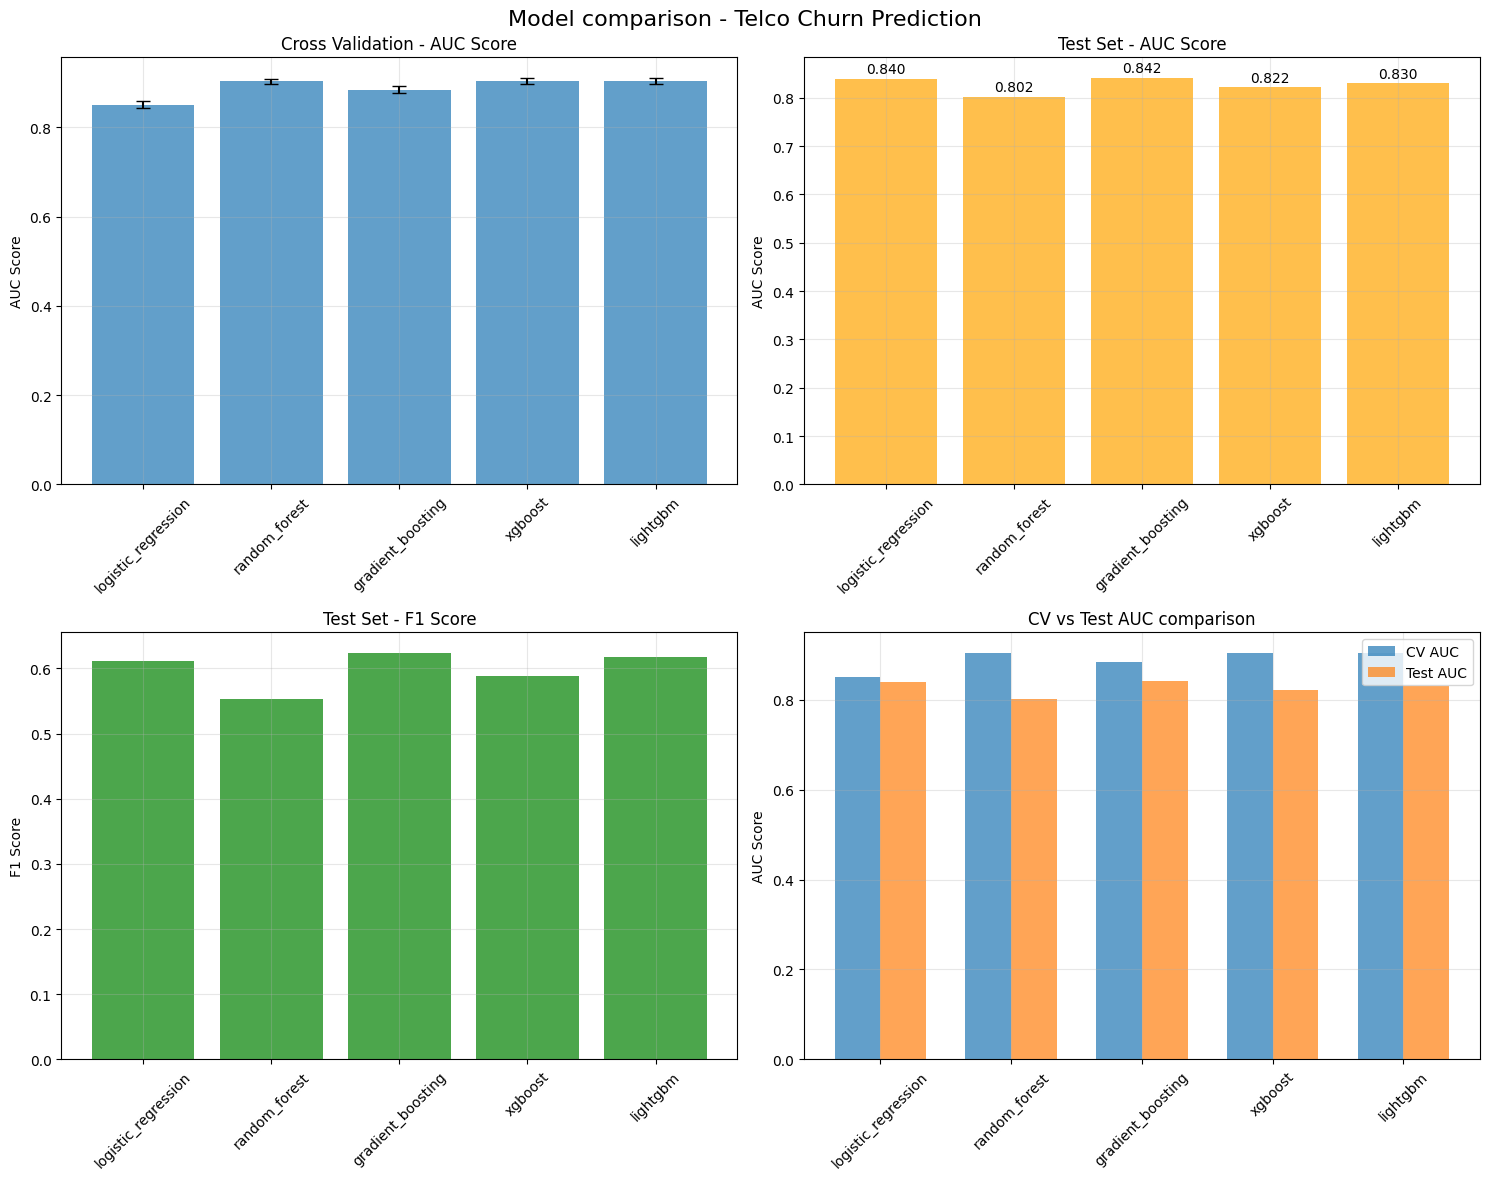

In [20]:
plot_model_comparison()

We can see all the models have very good results and the difference between them are very little. I'm creating an inference function that allows to check whether a customer is going to churn or not.

In [21]:
def predict_churn(customer_data, model_name='best',return_prob=True):
    """Churn predicting function."""
    # Checking models were trained.
    if 'baseline' not in results or not results['baseline']:
        print(f'Train the models first!')
        return None

    try:
        # Convert the customer info to dataframe if its necessary.
        if isinstance(customer_data, dict):
            customer_data = pd.DataFrame([customer_data])
        elif not isinstance(customer_data, pd.DataFrame):
            print(f'Customer data must be a DataFrame or dict.')
            return None 
        
        print(f'\n CHURN PREDICTION')
        print(f'-'*40)
        print(f'Number of customer to predict: {len(customer_data)}')
        
        # Selecting the model.
        valid_results = {k: v for k, v in results['baseline'].items() if v is not None}
        
        if model_name == 'best':
            # Selecting best model by CV AUC.
            best_model_name = max(valid_results.keys(), 
                                key=lambda x: valid_results[x]['cv_auc_mean'])
            model_name = best_model_name
            print(f"Model selected (best CV AUC): {model_name}")
        
        if model_name not in valid_results:
            print(f" Model '{model_name}' not found or valid")
            print(f" Available models: {list(valid_results.keys())}")
            return None
        
        model_info = valid_results[model_name]
        model = model_info['model']
        
        print(f'Using model: {model_name}')
        print(f'Model CV AUC: {model_info['cv_auc_mean']:.4f}')
        
        # Verifying that columns match.
        exp_cols = list(X_train.columns)
        cust_cols = list(customer_data.cols)
        missing_cols = set(exp_cols) - set(cust_cols)
        extra_cols = set(cust_cols) - set(exp_cols)
        
        if missing_cols:
            print(f'Missing columns: {missing_cols}')
            print(f'Filling with 0...')
            for col in missing_cols:
                customer_data[col] = 0
        
        if extra_cols:
            print(f'Extra columns (will be ignored): {extra_cols}')
            customer_data = customer_data[exp_cols]
        
        # Sorting columns to match.
        customer_data = customer_data[exp_cols]
        
        # Make predictions.
        predictions = model.predict(customer_data)

        results_dict = {
            'model_used': model_name,
            'model_cv_auc': model_info['cv_auc_mean'],
            'predictions': predictions,
            'predictions_labels': ['No Churn' if p == 0 else 'Churn' for p in predictions]
        }
        # Churn probabilities.
        if return_prob:
            probabilities = model.predict_proba(customer_data)
            results_dict['probabilities'] = probabilities
            results_dict['churn_probability'] = probabilities[:, 1]
        
        # Displaying results.
        print(f'\n PREDICTION RESULTS:')
        print(f'-'*40)
        for i in range(len(customer_data)):
            prob_text = ""
            if return_prob:
                prob_text = f' (prob: {results_dict['churn_probability'][i]:.3f})'
            print(f'Customer {i+1}: {results_dict["predictions_labels"][i]}{prob_text}')
        
        # Summary.
        churn_count = sum(predictions)
        no_churn_count = len(predictions) - churn_count
        print(f"\n SUMMARY:")
        print(f"No Churn: {no_churn_count} customers")
        print(f"Churn: {churn_count} customers")
        print(f"Predicted churn rate: {churn_count/len(predictions):.1%}")
        
        return results_dict
    
    except Exception as e:
        print(f'Encountered error while predicting: {str(e)}')
        return None 